# Optimization: Gradient Descent

_From [Dataflowr Module 4](https://dataflowr.github.io/website/modules/4-optimization-for-deep-learning/) by Marc Lelarge, initially adapted from [Optimization chapter](http://www.d2l.ai/chapter_optimization/) of Dive into Deep Learning._

The objective function of an optimization algorithm is usually a loss function based on the training dataset. Hence, the goal of optimization is to reduce the **training error** on the **training dataset**.

However, the goal of (deep) learning is to reduce the **generalization error** on the **test dataset**.

In order to reduce the generalization error, we need to pay attention to **overfitting** in addition to using the optimization algorithm to reduce the training error.

Here we focus specifically on the performance of the optimization algorithm in minimizing the objective function, rather than the model's generalization error.

In [37]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

## Mini-Torch: Tensors and Gradients

First things first: to implement SGD, we need to be able to compute the gradient of our loss function.
In practice, PyTorch does this automatically for us using _backpropagation_ (see [3-autodiff](3-autodiff/autodiff.ipynb)).

### PyTorch Tensors

In PyTorch, a `tensor` has a Boolean field `requires_grad` (set to `False` by default) which specifies whether PyTorch will track operations to compute the gradient.

In [38]:
import torch

x1 = torch.tensor(-5.0, requires_grad=True)
x2 = torch.tensor(-2.0, requires_grad=True)

Tensors are objects with a `grad` attribute that stores the gradient computed during the `backward` pass (see [3-autodiff](3-autodiff/autodiff.ipynb)).

In [39]:
x1.requires_grad_(True)
x2.requires_grad_(True)

print(x1.grad, x2.grad)

None None


Initially the gradients are `None`. 
Let's try `backward` after computing the result of a simple function.

In [40]:
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

In [41]:
l = f_2d(x1, x2)
l.backward()
print(x1.grad, x2.grad)

tensor(-1.) tensor(-8.)


Can you check these results?

TODO

0.2 * x1 et 4 * x2

To understand what happens under the hood, let's reimplement a (very) simplified version of PyTorch's infrastructure.

### Tensors and Backprop

First, we need to redefine the arithmetic operators to implement the backprop algorithm to compute gradients. You already did most of the work in [tp-3-backprop](3-autodiff/tp-3-backprop.ipynb). We define a class for each operator where the `backward` method implements the local chain rule.

In [42]:
class Add:
    def __init__(self, left, right, result):
        self.left = left
        self.right = right
        self.result = result
    
    def backward(self):
        self.left.grad += self.result.grad
        self.right.grad += self.result.grad

class Mul:
    def __init__(self, left, right, result):
        self.left = left
        self.right = right
        self.result = result
    
    def backward(self):
        self.left.grad += self.right.value * self.result.grad
        self.right.grad += self.left.value * self.result.grad

class Pow:
    def __init__(self, base, n, result):
        self.base = base
        self.n = n
        self.result = result
    
    def backward(self):
        self.base.grad += self.n * self.base.value ** (self.n - 1) * self.result.grad


Now a `Tensor` is a simple object with a `value` attribute and a `grad` attribute to store the gradient computed by `backward`.

Compared to [tp-3-backprop](3-autodiff/tp-3-backprop.ipynb):
- We overload the definition of arithmetic operators to directly use the syntax `(x + 2) * 2` (see also [dual_numbers](3-autodiff/dual-numbers.ipynb)).
- We store all the operations in an `operations` attribute (instead of using an explicit `MyComposition` with a list of operations).

In [43]:
class Tensor:    
    def __init__(self, value):
        self.value = value
        self.grad = 0.0
        self.operations = []
    
    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        result = Tensor(self.value + other.value)
        result.operations = self.operations + other.operations + [Add(self, other, result)]
        return result
    
    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        result = Tensor(self.value * other.value)
        result.operations = self.operations + other.operations + [Mul(self, other, result)]
        return result
    
    def __pow__(self, n):
        result = Tensor(self.value ** n)
        result.operations = self.operations + [Pow(self, n, result)]
        return result
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def backward(self):
        self.grad = 1
        for op in reversed(self.operations):
            op.backward()

Now let's test it on our simple example.

In [68]:
# TODO
x1 = Tensor(-5.0)
x2 = Tensor(-2.0)

print(x1.grad, x2.grad)
l = f_2d(x1, x2)
l.backward()
print(x1.grad, x2.grad)

0.0 0.0
-1.0 -8.0


### Optimizer

Following PyTorch conventions, we can now define our own `Optimizer` class.
An optimizer stores the parameters to optimize (a list of tensors), and we need to define two methods to implement an optimizer:
- `zero_grad`: resets the gradient of the parameters (otherwise we accumulate the gradient across multiple steps).
- `step`: where the optimization happens, and depends on the algorithm (see below).

In [45]:
class Optimizer:
    def __init__(self, params):
        self.params = params
    
    def zero_grad(self):
        """Zero out the gradients of all parameters."""
        for param in self.params:
            param.grad = 0.0

    def step(self):
        raise NotImplementedError

Now it's time to implement our own optimizers!

## Gradient Descent

In the following, we are trying to minimize a cost function $J(\theta; x, y)$ with parameters $\theta$ on a training set $(x, y)$ (containing $n$ elements $(x_i, y_i)$).

Even if the problem is not convex, we can still compute the gradient of the cost function $\nabla J(\theta)$ with respect to the parameters.

We can thus implement a **training loop** where at each step $t$ we update the parameters in the opposite direction of the gradient.
The learning rate $\eta$ determines the size of the steps.

- Batch gradient descent: $\theta_{t+1} = \theta_t - \eta \nabla J(\theta_t)$
- Stochastic gradient descent: $\theta_{t+1} = \theta_t - \eta \nabla J(\theta_t; x_i, y_i)$
- Mini-batch gradient descent: $\theta_{t+1} = \theta_t - \eta \nabla J(\theta_t; x_{i:i+b}, y_{i:i+b})$ (where $b$ is the batch size)


Mini-batch gradient descent is the algorithm of choice when training a neural network. 
The term SGD is usually used also when mini-batches are employed.

**Limitations**
- Choosing a proper learning rate can be difficult. 
- How to adapt the learning rate during training?
- Why apply the same learning rate to all parameter updates?
- How to escape saddle points where the gradient is close to zero in all dimensions?

In [46]:
# Create grid
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_range, y_range)

# Saddle function: z = x^2 - y^2
Z = X**2 - Y**2

fig = go.Figure(data=[
    go.Surface(
        x=x_range,
        y=y_range,
        z=Z,
        colorscale='Viridis',
        opacity=0.9
    ),
    go.Scatter3d(
        x=[0],
        y=[0],
        z=[0],
        mode='markers',
        marker=dict(size=10, color='red'),
        name='Saddle Point'
    )
])

fig.update_layout(
    width=600,
    height=600,
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z',
        aspectmode='cube',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
)

fig.show()

In the rest of this notebook, we will introduce modifications to SGD.
We will apply these modifications to mini-batch gradient descent, but to simplify the presentation, in the rest of the notebook we use a toy example and omit the explicit reference to the batch. 
But keep in mind that in reality, updates are performed for every mini-batch.

To illustrate different optimizers, we focus on the simple function `f_2d` that we used to illustrate `backprop` above.

$$f(x_1, x_2) = 0.1 \cdot x_1^2 + 2 \cdot x_2 ^2$$

We want to find the parameters $\theta^* = (x_1, x_2)$ that minimize $f$. If we look at the surface, the optimization problem is similar to the linear regression in [2-basics](2-basics/linear-regression.ipynb).

In [47]:
# Create grid
x1_range = np.linspace(-10, 10, 100)
x2_range = np.linspace(-10, 10, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Compute function values
Z = f_2d(X1, X2)

fig = go.Figure(data=[
    go.Surface(
        x=x1_range,
        y=x2_range,
        z=Z,
        colorscale='Viridis',
        opacity=0.8,
        name='Function Surface'
    )
])

fig.update_layout(
    width=600,
    height=600,
    scene=dict(
        xaxis_title='x₁',
        yaxis_title='x₂',
        zaxis_title='f(x₁, x₂)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
)

fig.show()


Here is the training loop for `f_2d`.
Thanks to the overloading of arithmetic operators, we can directly call `f_2d` on our tensors, and then use the `backward` method on the result.
The code is extremely similar to PyTorch.

In [ ]:
def train(optimizer, x1_init, x2_init, num_steps=20):
    x1.value = x1_init
    x2.value = x2_init

    res = [tuple(p.value for p in optimizer.params)]
    
    for i in range(num_steps):
        # Clear gradients (zero_grad)
        optimizer.zero_grad()
        # Forward pass
        l = f_2d(x1, x2)
        # Backward pass (populate gradients)
        l.backward()
        # Update parameters
        optimizer.step()
    
        res.append(tuple(p.value for p in optimizer.params))
    
    print('epoch %d, params: %s' % (i+1, res[-1]))
    return res

Now let's implement the classic optimizers!

### Basic SGD

The following optimizer implements the most basic gradient descent:

$$\theta_{t+1} = \theta_t - \eta \nabla J(\theta_t)$$

In [70]:
class GradientDescent(Optimizer):
    """Gradient Descent optimizer."""
    
    def __init__(self, params, eta=0.4):
        self.eta = eta
        super().__init__(params)
    
    def step(self):
        for param in self.params:
            param.value -= self.eta * param.grad

In [71]:
def show_trace_2d(res, color='red'):
    """Show the trace of 2d variables during optimization."""
    x1, x2 = zip(*res)
    plt.plot(x1, x2, '-o', color=color)
    x1_grid = np.arange(-5.5, 3.5, 0.1)
    x2_grid = np.arange(min(-3.0, min(x2) - 1), max(1.0, max(x2) + 1), 0.1)
    x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)
    
    z = 0.1 * x1_mesh ** 2 + 2 * x2_mesh ** 2
    
    plt.contour(x1_mesh, x2_mesh, z, colors='blue')
    plt.xlabel('x1')
    plt.ylabel('x2')

Depending on the learning rate, we can see oscillations...

epoch 20, params: (-0.9434666458139824, -7.312316880125978e-05)


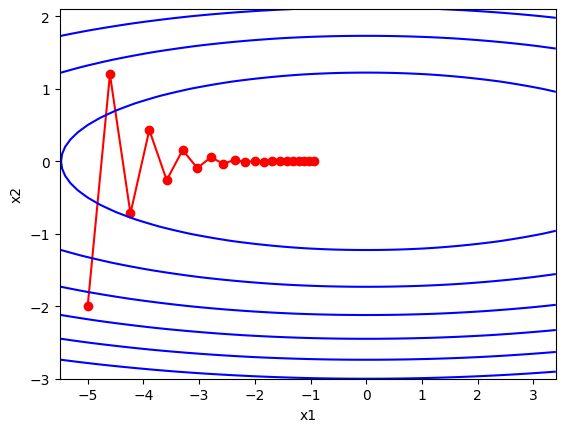

In [72]:
gd = GradientDescent([x1, x2], eta=0.4)
show_trace_2d(train(gd, x1_init=-5.0, x2_init=-2.0))

Or divergence...

epoch 20, params: (-0.38781396819094793, -1673.365108505695)


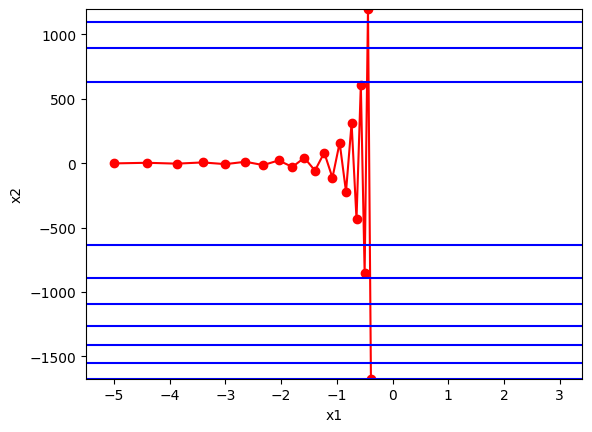

In [73]:
gd = GradientDescent([x1, x2], eta=0.6)
show_trace_2d(train(gd, x1_init=-5.0, x2_init=-2.0))

### Momentum

A first idea is to accelerate SGD by dampening oscillations, i.e., by averaging the last values of the gradient.

\begin{align*}
v_{t+1} &= \gamma v_t + \eta \nabla J(\theta_t)\\
\theta_{t+1} &= \theta_t - v_{t+1}
\end{align*}

We have for any $k > 0$:

$$
v_{t+1} = \gamma^k v_{t - k} + \eta \underbrace{\sum_{i=0}^k \gamma^i \nabla J(\theta_{t-i})}_{\text{average of the last gradients}}
$$

Typical value for $\gamma = 0.9$

In [ ]:
class Momentum(Optimizer):
    """Momentum optimizer."""
    
    def __init__(self, params, eta=0.4, gamma=0.5):
        self.eta = eta
        self.gamma = gamma
        super().__init__(params)
        # Initialize velocity for each parameter
        self.v = [0.0 for _ in self.params]
    
    def step(self):
        for i, param in enumerate(self.params):
            # On met à jour la vélocité
            self.v[i] = self.gamma * self.v[i] + self.eta * param.grad
            # On met à jour les params
            param.value -= self.v[i]

epoch 20, params: (-0.06284345503037868, 0.0012023355717834623)


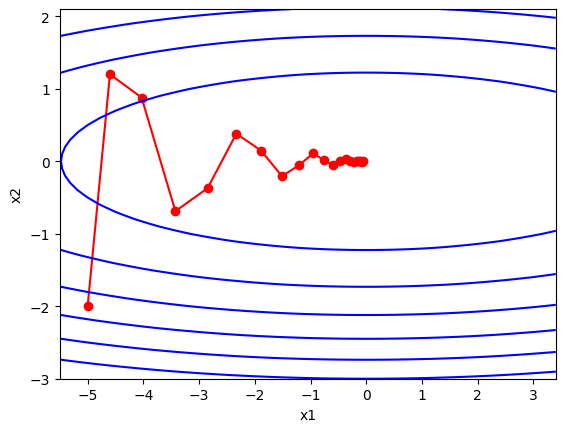

In [75]:
momentum = Momentum([x1, x2], eta=0.4, gamma=0.5)
show_trace_2d(train(momentum, x1_init=-5.0, x2_init=-2.0))

epoch 20, params: (0.007187866737294238, 0.0025532747547120727)


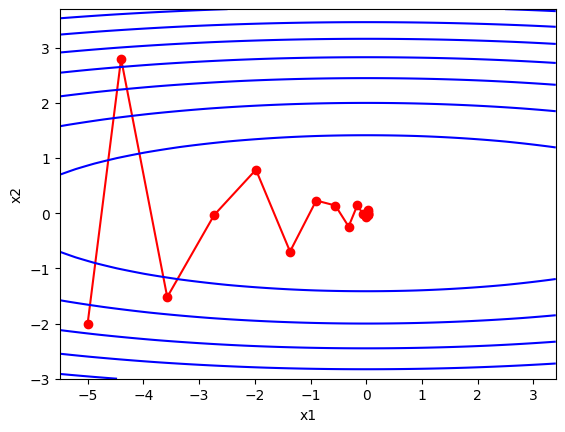

In [76]:
momentum = Momentum([x1, x2], eta=0.6, gamma=0.5)
show_trace_2d(train(momentum, x1_init=-5.0, x2_init=-2.0))

epoch 20, params: (-0.5891108877866227, 0.6985052331838697)


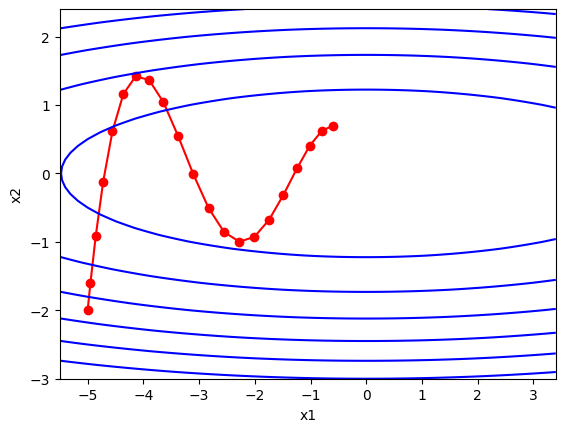

In [77]:
momentum = Momentum([x1, x2], eta=0.05, gamma=0.9)
show_trace_2d(train(momentum, x1_init=-5.0, x2_init=-2.0))

### Nesterov

With momentum, we first compute the gradient and then make a step following our momentum and add the gradient. Nesterov proposed to first make the step following the momentum and then adjust by computing the gradient locally.

\begin{align*}
v_{t+1} &= \gamma v_t + \eta \nabla J(\theta_t - \gamma v_t)\\
\theta_{t+1} &= \theta_t - v_{t+1}
\end{align*}

Unfortunately, this formulation requires computing the gradient at the lookahead position $\theta_t - \gamma v_t$, but the optimizer only has access to the gradient at position $\theta_t$.

We can instead use the following reformulation: 

\begin{align*} 
v_{t+1} &= \gamma v_t + \eta \nabla J(\theta_t)\\
\theta_{t+1} &= \theta_t - \gamma v_{t+1} - \eta \nabla J(\theta_t) 
\end{align*} 

We compute the gradient at the current position $\theta_t$ and apply both the momentum term $\gamma v_{t+1}$ and the gradient term $\eta \nabla J(\theta_t)$ directly to the parameters. The two formulations are mathematically equivalent through the change of variables: $\tilde{\theta}_t = \theta_t - \gamma v_t$.

In [84]:
class Nesterov(Optimizer):
    """Nesterov Accelerated Gradient optimizer."""
    
    def __init__(self, params, eta=0.05, gamma=0.9):
        self.eta = eta
        self.gamma = gamma
        super().__init__(params)
        # Initialize velocity for each parameter
        self.v = [0.0 for _ in self.params]
    
    def step(self):
        for i, param in enumerate(self.params):
            self.v[i] = self.gamma * self.v[i] + self.eta * param.grad
            param.value -= self.gamma * self.v[i] + self.eta * param.grad

epoch 20, params: (-0.5763880581378493, 0.0789949073538188)
epoch 20, params: (-0.5891108877866227, 0.6985052331838697)


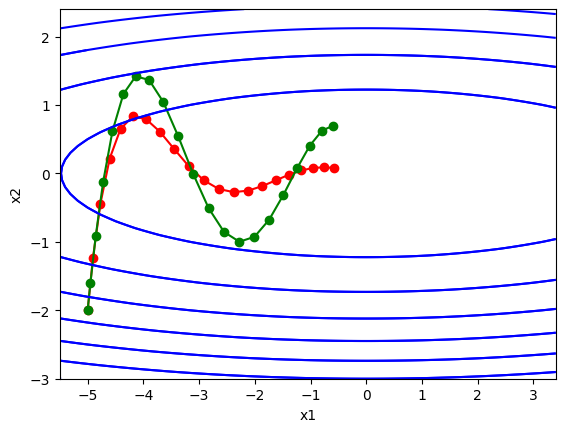

In [85]:
nesterov = Nesterov([x1, x2], eta=0.05, gamma=0.9)
show_trace_2d(train(nesterov, x1_init=-5.0, x2_init=-2.0))

momentum = Momentum([x1, x2], eta=0.05, gamma=0.9)
show_trace_2d(train(momentum, x1_init=-5.0, x2_init=-2.0), color='green')

### Adagrad

Another idea is to adapt our updates to each individual parameter, i.e., have a different decreasing learning rate for each parameter.

\begin{align*}
s_{t+1,i} &= s_{t,i} + \nabla J(\theta_t)_i^2\\
\theta_{t+1,i} &= \theta_{t,i} - \frac{\eta}{\sqrt{s_{t+1,i} + \epsilon}} \nabla J(\theta_t)_i
\end{align*}

No manual tuning of the learning rate required.

Typical default values: $\eta = 0.01$ and $\epsilon = 1e-8$

In [86]:
import math

class Adagrad(Optimizer):
    """Adagrad optimizer."""
    
    def __init__(self, params, eta=0.4, eps=1e-6):
        self.eta = eta
        self.eps = eps
        super().__init__(params)
        # Initialize accumulated squared gradients for each parameter
        self.s = [0.0 for _ in self.params]
    
    def step(self):
        for i, param in enumerate(self.params):
            self.s[i] = self.s[i] + param.grad ** 2
            param.value -= self.eta * param.grad / math.sqrt(self.s[i] + self.eps)

epoch 20, params: (-2.382562771979649, -0.15859055003666966)


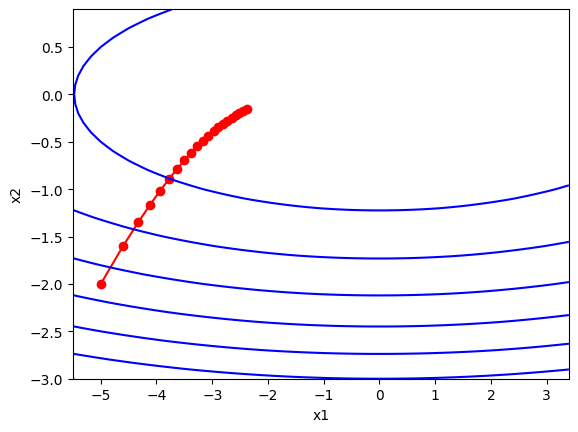

In [87]:
adagrad = Adagrad([x1, x2], eta=0.4)
show_trace_2d(train(adagrad, x1_init=-5.0, x2_init=-2.0))

epoch 20, params: (-0.002295340252192116, -1.4349293303459627e-162)


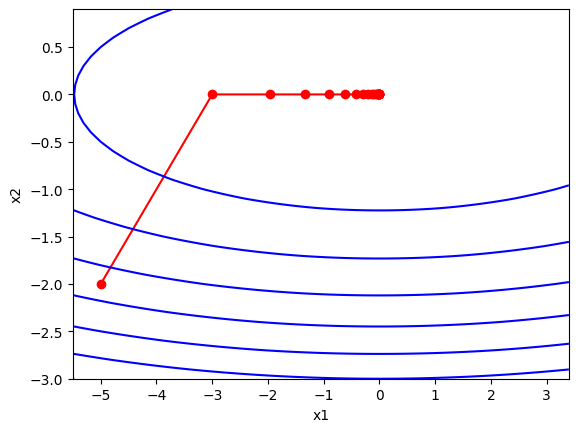

In [88]:
adagrad = Adagrad([x1, x2], eta=2)
show_trace_2d(train(adagrad, x1_init=-5.0, x2_init=-2.0))

### RMSProp

Unfortunately, with Adagrad the learning rate goes to zero and never forgets about the past.
Idea proposed by G. Hinton in his Coursera class: use exponential average.

\begin{align*}
s_{t+1,i} &= \gamma s_{t,i} + (1-\gamma)\nabla J(\theta_t)_i^2\\
\theta_{t+1,i} &= \theta_{t,i} - \frac{\eta}{\sqrt{s_{t+1,i} + \epsilon}} \nabla J(\theta_t)_i
\end{align*}

Typical default values: $\gamma = 0.9$ and $\eta = 0.001$

In [89]:
class RMSProp(Optimizer):
    """RMSProp optimizer."""
    
    def __init__(self, params, eta=0.4, gamma=0.9, eps=1e-6):
        self.eta = eta
        self.gamma = gamma
        self.eps = eps
        super().__init__(params)
        # Initialize exponential moving average of squared gradients
        self.s = [0.0 for _ in self.params]
    
    def step(self):
        for i, param in enumerate(self.params):
            self.s[i] = self.gamma * self.s[i] + (1 - self.gamma) * param.grad ** 2
            param.value -= self.eta * param.grad / math.sqrt(self.s[i] + self.eps)

epoch 20, params: (-0.010598672134113715, 1.0362121337275144e-14)


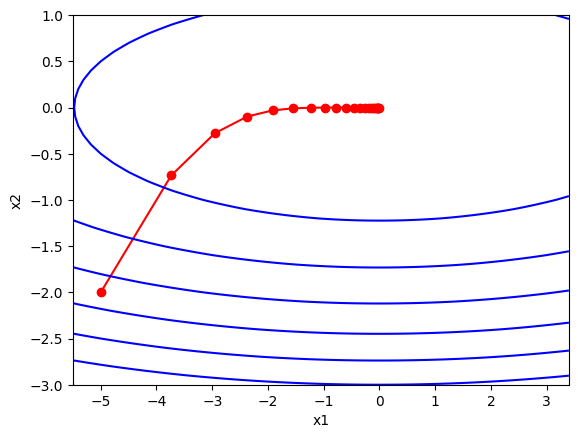

In [90]:
rmsprop = RMSProp([x1, x2], eta=0.4, gamma=0.9)
show_trace_2d(train(rmsprop, x1_init=-5.0, x2_init=-2.0))

## Adam

Mixing ideas from RMSProp and momentum, we get Adam = Adaptive Moment Estimation (that you used in [TP-5](5-CNN/tp-5-cnn.ipynb)).

\begin{align*}
m_{t+1,i} &= \beta_1 m_{t,i} + (1-\beta_1)\nabla J(\theta_t)_i\\
v_{t+1,i} &= \beta_2 v_{t,i} + (1-\beta_2)\nabla J(\theta_t)_i^2\\
\hat{m}_{t+1,i} &= \frac{m_{t+1,i}}{1-\beta_1^{t+1}}\\
\hat{v}_{t+1,i} &= \frac{v_{t+1,i}}{1-\beta_2^{t+1}}\\
\theta_{t+1,i} &= \theta_{t,i} - \frac{\eta}{\sqrt{\hat{v}_{t+1,i}} + \epsilon} \hat{m}_{t+1,i}
\end{align*}

$\hat{m}_t$ and $\hat{v}_t$ are estimates for the first and second moments of the gradients. 
Because $m_0 = v_0 = 0$, these estimates are biased towards $0$. The factors $\frac{1}{(1 - \beta^{t+1})}$ are here to counteract these biases.

Typical values: $\beta_1 = 0.9$, $\beta_2 = 0.999$, and $\epsilon = 1e-8$

In [98]:
class Adam(Optimizer):
    """Adam optimizer."""
    
    def __init__(self, params, eta=0.8, beta1=0.9, beta2=0.99, eps=1e-6):
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        super().__init__(params)
        # Initialize first and second moment estimates
        self.m = [0.0 for _ in self.params]
        self.v = [0.0 for _ in self.params]
        self.t = 0
    
    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad ** 2
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            param.value -= self.eta * m_hat / (math.sqrt(v_hat) + self.eps)

epoch 20, params: (0.4142175214075523, 0.08613755831937331)


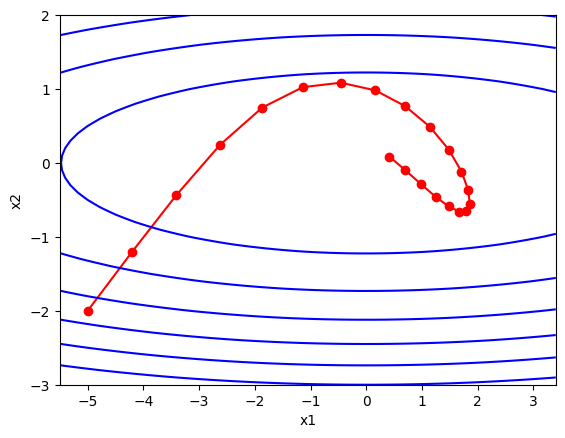

In [99]:
adam = Adam([x1, x2], eta=0.8)
show_trace_2d(train(adam, x1_init=-5.0, x2_init=-2.0))

## AMSGrad

Sometimes, Adam forgets too fast. To fix this, we replace the moving average with a max.

\begin{align*}
m_{t+1,i} &= \beta_1 m_{t,i} + (1-\beta_1)\nabla J(\theta_t)_i\\
v_{t+1,i} &= \beta_2 v_{t,i} + (1-\beta_2)\nabla J(\theta_t)_i^2\\
\hat{v}_{t+1,i} &= \max(\hat{v}_{t,i}, v_{t+1,i})\\
\theta_{t+1,i} &= \theta_{t,i} - \frac{\eta}{\sqrt{\hat{v}_{t+1,i}} + \epsilon} m_{t+1,i}
\end{align*}

In [ ]:
class AMSGrad(Optimizer):
    """AMSGrad optimizer."""
    
    def __init__(self, params, eta=1.0, beta1=0.9, beta2=0.99, eps=1e-6):
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        super().__init__(params)
        # Initialize first and second moment estimates, and max second moment
        self.m = [0.0 for _ in self.params]
        self.v = [0.0 for _ in self.params]
        self.v_max = [0.0 for _ in self.params]
        self.t = 0
    
    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad ** 2
            self.v_max[i] = max(self.v_max[i], self.v[i])
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v_max[i] / (1 - self.beta2 ** self.t)
            param.value -= self.eta * m_hat / (math.sqrt(v_hat) + self.eps)

epoch 20, params: (-5.0, -2.0)
epoch 20, params: (-0.5711392962567305, 0.4875526114389969)


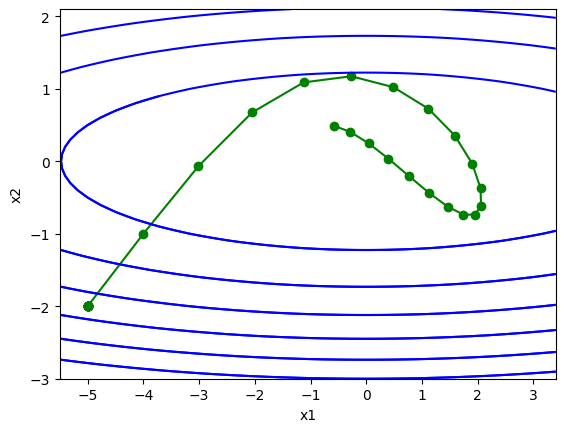

In [103]:
amsgrad = AMSGrad([x1, x2], eta=1)
show_trace_2d(train(amsgrad, x1_init=-5.0, x2_init=-2.0))


adam = Adam([x1, x2], eta=1)
show_trace_2d(train(adam, x1_init=-5.0, x2_init=-2.0), color='green')

Want more? See also [Sebastien Ruder "An overview of gradient descent optimization algorithms" (2016)](https://www.ruder.io/optimizing-gradient-descent/)

### PyTorch Optimizers

All these optimizers are implemented in PyTorch in [torch.optim](https://docs.pytorch.org/docs/stable/optim.html).
The implementation is similar to our own.
The constructors take as arguments:
- A list of parameters to optimize (can be obtained from a module with `module.parameters()`).
- The hyperparameters `lr`, `momentum`, etc. The default values are different for all optimizers—check the documentation.